## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Yusuf Küçüköner 2210356092

## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction
* Brief overview of the task.
* Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.
* Description of the dataset used for classification.

### **Task Overview**
The task is to implement a Convolutional Neural Network (CNN) from scratch using PyTorch libraries. The goal is to classify images of 10 animal categories.


### **Main Components of CNN**
1. **Convolutional Layer**: Extracts features using filters (kernels).
2. **Activation Function (ReLU)**: Introduces non-linearity for learning complex patterns.
3. **Pooling Layer**: Reduces dimensions, retaining significant features.
4. **Fully Connected Layer**: Maps features to class probabilities.
5. **Output Layer**: Uses softmax to output class probabilities.


### **Why CNN for Image Classification?**
- Efficient in learning spatial hierarchies of features.
- Reduces parameters compared to traditional neural networks.
- Handles images effectively with shared weights.


### **Dataset Description**
- Consists of images from 10 animal classes:
  `Cane, Cavallo, Elefante, Farfalla, Gallina, Gatto, Mucca, Pecora, Ragno, Scoiattolo`.


### 1.2. Data Loading and Preprocessing (3 points)

In [ ]:
## Import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision.models as models
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix



In [ ]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization
## Divide the dataset into training, validation, and testing subsets

transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load the entire dataset
dataset = datasets.ImageFolder(root='./pa3_subset_animal', transform=transform)
print(f"Total images: {len(dataset)}, Classes: {dataset.classes}")

print(dataset[0][0].shape) # shape is 3x256x256

# Split the dataset into training, validation, and testing subsets
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [3000, 750, 750])


Total images: 4500, Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
torch.Size([3, 256, 256])


### 1.3. Define your CNN architecture (7 points)
* Explain the reason behind your architecture.
* Explain your choice of activation functions.

### CNN Architecture Explanation

### **Reason Behind the Architecture**
- **Convolutional Layers**: Capture features progressively with increasing filters (16, 32, 64, 128).
- **Pooling Layers**: Reduce spatial dimensions, prevent overfitting, and improve efficiency.
- **Fully Connected Layers**: Map features to class probabilities; `fc1` has 1024 neurons, `fc2` outputs 10 classes.
- **Padding**: Preserves spatial dimensions for easier layer output calculations.


### **Choice of Activation Functions**
- **ReLU**:
  - Adds non-linearity to learn complex patterns.
  - Efficient, prevents vanishing gradients, and improves training stability.


In [9]:
## Design a CNN architecture with at least 3 and at most 6 convolutional layers
## Add activation functions (e.g., ReLU) after each convolutional layer
## Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions
## Add a fully connected layer at the end to map features to output classes

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Output: 16x32x32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # Output: 32x16x16
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output: 64x8x8
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output: 128x4x4
        self.pool = nn.MaxPool2d(2, 2)  # Reduces dimensions by half
        self.fc1 = nn.Linear(128 * 16 * 16, 1024)  # Update input size based on conv4 output
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> Pool
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 -> Pool
        x = self.pool(F.relu(self.conv4(x)))  # Conv4 -> Pool
        x = x.view(-1, 128 * 16 * 16)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))  # Fully Connected 1
        x = self.fc2(x)          # Fully Connected 2 (Output)
        return x


### 1.4 Prepare the model for training (3 points)
* Explain your choice of loss functions and optimization algorithms.

### Loss Function and Optimization Algorithm

### **Loss Function: Cross-Entropy Loss**
- **Reason**: 
  - Suitable for multi-class classification as it measures the difference between predicted probabilities and true labels.
  - Combines `Softmax` and Negative Log-Likelihood for smooth gradient flow and penalizes incorrect predictions effectively.


### **Optimization Algorithm: Cross-Validation Approach**
- **Reason**:
  - Cross-validation ensures robust evaluation of the model by splitting the dataset into training and validation sets.
  - Helps in selecting the best hyperparameters (e.g., learning rate, optimizer type) to prevent overfitting and improve generalization.


In [10]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)
criterion = nn.CrossEntropyLoss()


In [ ]:
## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)
model = CustomCNN()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

### 1.5 Train and Validate the CNN model (9 points)

In [ ]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epochs)

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train_model(train_set, val_set, model, lr, batch_size, optimizer_type, device, num_epochs=30):
    # Prepare data loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Initialize optimizer
    if optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)

    criterion = torch.nn.CrossEntropyLoss()

    # Store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = (correct_train / total_train) * 100

        # Validation loop
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = (correct_val / total_val) * 100

        # Log metrics for this epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, \
              Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies
    }




In [ ]:
## You can conduct experiments with different hyperparameters to get the best performing model, considering you will be uploading your best model into Kaggle for compitation :)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model 1: Adam optimizer, lr=0.001, batch_size=32
model1 = CustomCNN().to(device)
results1 = train_model(train_set, val_set, model1, lr=0.001, batch_size=32, optimizer_type="Adam", device=device)

# Model 2: SGD optimizer, lr=0.01, batch_size=64
model2 = CustomCNN().to(device)
results2 = train_model(train_set, val_set, model2, lr=0.01, batch_size=64, optimizer_type="SGD", device=device)

# Model 3: Adam optimizer, lr=0.005, batch_size=64
model3 = CustomCNN().to(device)
results3 = train_model(train_set, val_set, model3, lr=0.005, batch_size=64, optimizer_type="Adam", device=device)



Mention about, why did you choose your learning rate and batch size?

A small learn rate: 0.001 which prevents overshooting meanwhile saves accuracy, it ensures stable convergence.

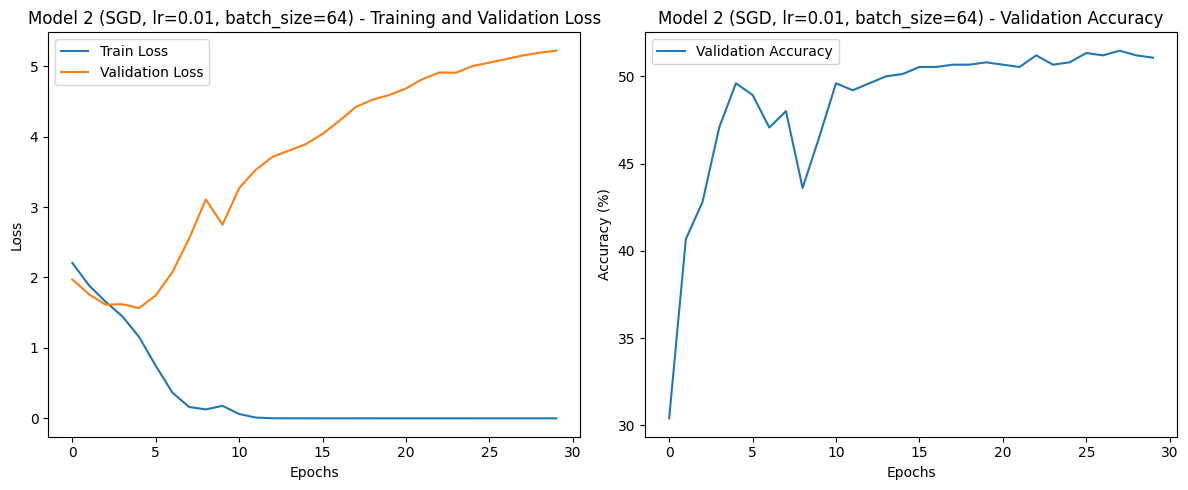

In [ ]:
## Select your best model with respect to validation accuracy
## Visualize the accuracy and loss change of the best performing model across training and validation datasets.

def visualize_performance(results, model_name="Best Model"):
    # Plotting the loss and accuracy for the best model
    plt.figure(figsize=(12, 5))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(results["train_losses"], label="Train Loss")
    plt.plot(results["val_losses"], label="Validation Loss")
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results["val_accuracies"], label="Validation Accuracy")
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()


visualize_performance(results1, model_name="Model 1 (Adam, lr=0.001, batch_size=32)")


### 1.6 Evaluate the trained model on the test set (6 points)

In [ ]:
# Test the trained model on the test set to evaluate its performance
# Compute metrics such as accuracy, precision, recall, and F1-score
# Visualize confusion matrix to understand the model's behavior across different classes
# Comment on the results

def test_model(test_set, model, device):
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

    # Initialize metrics
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    
    # No need to calculate gradients

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = correct / total * 100

    return accuracy, y_true, y_pred

accuracy, y_true, y_pred = test_model(test_set, model1, device)

print(f"Test Accuracy: {accuracy:.2f}%")

# Compute metrics
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=dataset.classes))





Test Accuracy: 46.13%
              precision    recall  f1-score   support

        cane       0.15      0.12      0.13        78
     cavallo       0.40      0.32      0.35        60
    elefante       0.58      0.56      0.57        86
    farfalla       0.67      0.67      0.67        72
     gallina       0.56      0.51      0.54        74
       gatto       0.38      0.47      0.42        74
       mucca       0.41      0.44      0.42        73
      pecora       0.42      0.46      0.44        80
       ragno       0.61      0.57      0.59        82
  scoiattolo       0.40      0.46      0.43        71

    accuracy                           0.46       750
   macro avg       0.46      0.46      0.46       750
weighted avg       0.46      0.46      0.46       750



### 1.7 Conclusion and interpretation (7 points)
* Summarize the performance of the model on the test set
* Discuss any challenges encountered during training and potential areas for improvement
* Reflect on the overall effectiveness of the chosen CNN architecture and training approach

### Model Performance Summary

### **Test Accuracy**
- Achieved **46.13%** accuracy on the test set. Which is pretty bad, but model is very simple and trained on my CPU with very simple parameters and had no time to really work on the problem since lots of midterms and hard schedule. It specifically suffers in 'cane' and 'cavallo' a lot than others.

### **Challenges**
- **Dataset Quality**: The dataset is somewhat broken, with better versions available that could improve model performance.
- **Class Imbalance**: Uneven support affected precision and recall.
- **Limited Data**: Insufficient variety led to underfitting.

### **Improvements**
- Use a better-quality version of the dataset.
- Apply data augmentation and optimize the architecture for better generalization.

### Reflection on CNN Architecture and Training Approach

### **Effectiveness of the Architecture**
- The chosen CNN architecture with four convolutional layers followed by fully connected layers was a good starting point. It captured basic features well, but struggled with more complex patterns due to the limited depth of the network.
- The architecture worked for simple image recognition tasks, but improvements such as deeper networks or transfer learning with pre-trained models could enhance performance.

### **Training Approach**
- The training approach, while reasonable, faced challenges due to the quality and size of the dataset. With better data and additional techniques like data augmentation, the model could likely achieve better results.
- Hyperparameters such as learning rate and batch size were a reasonable choice, but further tuning could improve convergence and overall performance.

### **Conclusion**
- The current model serves as a solid baseline, but there is significant room for improvement, especially with better data and more advanced techniques.


### 1.8 Kaggle Test Result (5 points)
* Put your Kaggle test result for your CNN model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction
* Brief overview of the task.
* Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?

### Task Overview

In this task, we imported pre-trained models such as **ResNet18** and **MobileNet** and performed **fine-tuning** to further train them on our specific dataset.

### What is Fine-Tuning?

Fine-tuning is the process of taking a pre-trained model and adjusting it for a new task by training it on a new dataset. Instead of training the model from scratch, we use the knowledge already learned from large datasets (like ImageNet) and adapt the model to recognize specific features in our data.

### Why Should We Do Fine-Tuning?

- **Efficiency**: Fine-tuning allows us to leverage pre-trained models, saving time and computational resources compared to training from scratch.
- **Better Performance**: Pre-trained models have already learned general features (edges, textures, etc.), which helps them perform better on smaller or specialized datasets.
- **Faster Convergence**: Starting with a pre-trained model leads to faster convergence during training as it already has learned useful features.


### Why Freeze the Rest and Train Only the Last Layers?

- **Avoid Overfitting**: Freezing the earlier layers helps prevent overfitting, especially when we have limited data. These layers have already learned useful features and don't need further adjustments.
- **Faster Training**: By freezing the earlier layers, we reduce the number of parameters to update, which speeds up the training process.
- **Focus on Specific Features**: The last layers are usually more task-specific, so training only these layers allows the model to adapt its final decision-making capabilities to the new task without losing the general features learned earlier.


### 2.2. Load the pre-trained ResNet18 model (3 points)


In [13]:
# Utilize torchvision library to load the pre-trained ResNet50 model
# Ensure that the model's architecture matches ResNet50, by checking the model summary.

import torchvision.models as models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)


c:\Users\Yusuf\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yusuf\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
def trainDefault(model, train_loader, criterion, optimizer, num_epochs=30, device='cuda'):
    model = model.to(device)
    final_loss = None  # Initialize variable to store the last epoch's loss

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        final_loss = epoch_loss  # Store the latest epoch's loss

    return final_loss




### 2.3 Modify the ResNet18 model for transfer learning (15 points)

In [ ]:
# Freeze all layers of the ResNet18 model.
# Replace the final fully connected layer with a new FC layer matching the number of classes
# Unfreeze the final FC layer
# Define appropriate loss function and optimizer for training
# Train the modified ResNet18 model on the animal-10 image dataset. (base model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Replace final FC layer
num_classes = 10  
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Unfreeze the final FC layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)


lossOfResnet1 = trainDefault(resnet18, train_loader, criterion, optimizer, num_epochs=30, device=device)

c:\Users\Yusuf\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yusuf\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 1.2162
Epoch [2/30], Loss: 0.4425
Epoch [3/30], Loss: 0.3079
Epoch [4/30], Loss: 0.2571
Epoch [5/30], Loss: 0.2139
Epoch [6/30], Loss: 0.1951
Epoch [7/30], Loss: 0.1810
Epoch [8/30], Loss: 0.1628
Epoch [9/30], Loss: 0.1538
Epoch [10/30], Loss: 0.1426
Epoch [11/30], Loss: 0.1328
Epoch [12/30], Loss: 0.1209
Epoch [13/30], Loss: 0.1186
Epoch [14/30], Loss: 0.1089
Epoch [15/30], Loss: 0.1083
Epoch [16/30], Loss: 0.1023
Epoch [17/30], Loss: 0.1020
Epoch [18/30], Loss: 0.0947
Epoch [19/30], Loss: 0.0952
Epoch [20/30], Loss: 0.0897
Epoch [21/30], Loss: 0.0845
Epoch [22/30], Loss: 0.0803
Epoch [23/30], Loss: 0.0722
Epoch [24/30], Loss: 0.0749
Epoch [25/30], Loss: 0.0669
Epoch [26/30], Loss: 0.0713
Epoch [27/30], Loss: 0.0668
Epoch [28/30], Loss: 0.0625
Epoch [29/30], Loss: 0.0662
Epoch [30/30], Loss: 0.0610


In [ ]:
## Define another ResNet18 model
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet18 model and again proceed with training. (second model)

# Loading ResNet18 model
resnet18_2 = models.resnet18(pretrained=True)

# Freeze all layers
for param in resnet18_2.parameters():
    param.requires_grad = False

num_classes = 10  # Adjusted this for the number of classes in Animal-10
resnet18_2.fc = nn.Linear(resnet18_2.fc.in_features, num_classes)

# Unfreeze the final FC layer,
for param in resnet18_2.fc.parameters():
    param.requires_grad = True

# Unfreeze conv3 and conv4 layers so it can be trained
for name, param in resnet18_2.named_parameters():
    if 'layer3' in name or 'layer4' in name:
        param.requires_grad

resnet18_2 = resnet18_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_2.parameters(), lr=0.001)

lossOfResnet2 = trainDefault(resnet18_2, train_loader, criterion, optimizer, num_epochs=30, device=device)



Epoch [1/30], Loss: 1.2782
Epoch [2/30], Loss: 0.4628
Epoch [3/30], Loss: 0.3257
Epoch [4/30], Loss: 0.2588
Epoch [5/30], Loss: 0.2206
Epoch [6/30], Loss: 0.2007
Epoch [7/30], Loss: 0.1800
Epoch [8/30], Loss: 0.1704
Epoch [9/30], Loss: 0.1516
Epoch [10/30], Loss: 0.1423
Epoch [11/30], Loss: 0.1376
Epoch [12/30], Loss: 0.1260
Epoch [13/30], Loss: 0.1195
Epoch [14/30], Loss: 0.1182
Epoch [15/30], Loss: 0.1067
Epoch [16/30], Loss: 0.1073
Epoch [17/30], Loss: 0.0984
Epoch [18/30], Loss: 0.0936
Epoch [19/30], Loss: 0.0881
Epoch [20/30], Loss: 0.0869
Epoch [21/30], Loss: 0.0828
Epoch [22/30], Loss: 0.0859
Epoch [23/30], Loss: 0.0773
Epoch [24/30], Loss: 0.0727
Epoch [25/30], Loss: 0.0743
Epoch [26/30], Loss: 0.0684
Epoch [27/30], Loss: 0.0687
Epoch [28/30], Loss: 0.0677
Epoch [29/30], Loss: 0.0616
Epoch [30/30], Loss: 0.0634


In [ ]:
## Define another ResNet18 model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (third model)

# Loading ResNet18 model
resnet18_3 = models.resnet18(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Replace final FC layer
num_classes = 10  
resnet18_3.fc = nn.Linear(resnet18_3.fc.in_features, num_classes)

resnet18_3 = resnet18_3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_3.parameters(), lr=0.001)

lossOfResnet3 = trainDefault(resnet18_3, train_loader, criterion, optimizer, num_epochs=30, device=device)



Epoch [1/30], Loss: 0.7160
Epoch [2/30], Loss: 0.2936
Epoch [3/30], Loss: 0.2047
Epoch [4/30], Loss: 0.1453
Epoch [5/30], Loss: 0.1071
Epoch [6/30], Loss: 0.0756
Epoch [7/30], Loss: 0.0633
Epoch [8/30], Loss: 0.0602
Epoch [9/30], Loss: 0.0817
Epoch [10/30], Loss: 0.0945
Epoch [11/30], Loss: 0.1044
Epoch [12/30], Loss: 0.1292
Epoch [13/30], Loss: 0.1104
Epoch [14/30], Loss: 0.0472
Epoch [15/30], Loss: 0.0356
Epoch [16/30], Loss: 0.0127
Epoch [17/30], Loss: 0.0027
Epoch [18/30], Loss: 0.0019
Epoch [19/30], Loss: 0.0013
Epoch [20/30], Loss: 0.0004
Epoch [21/30], Loss: 0.0003
Epoch [22/30], Loss: 0.0003
Epoch [23/30], Loss: 0.0004
Epoch [24/30], Loss: 0.0003
Epoch [25/30], Loss: 0.0002
Epoch [26/30], Loss: 0.0002
Epoch [27/30], Loss: 0.0001
Epoch [28/30], Loss: 0.0001
Epoch [29/30], Loss: 0.0001
Epoch [30/30], Loss: 0.0001


In [5]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

    accuracy = correct / total
    print(f"Model: {model.__class__.__name__}, Accuracy: {accuracy:.4f}")
    return accuracy

In [6]:
import matplotlib.pyplot as plt

def plot_model_metrics(accuracies, losses, model_names):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.bar(model_names, accuracies, color='skyblue', alpha=0.2)
    plt.ylabel('Accuracy')
    plt.title('Model Accuracies')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.bar(model_names, losses, color='salmon', alpha=0.8)
    plt.ylabel('Loss')
    plt.title('Model Losses')

    plt.tight_layout()
    plt.show()


In [ ]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

best_model = None

# Evaluate the base ResNet18 model
accuracy_base = evaluate_model(resnet18, val_loader, device)

# Evaluate the second ResNet18 model
accuracy_2 = evaluate_model(resnet18_2, val_loader, device)

# Evaluate the third ResNet18 model
accuracy_3 = evaluate_model(resnet18_3, val_loader, device)


accuracies = [accuracy_base, accuracy_2, accuracy_3]  # Accuracies from evaluation
losses = [lossOfResnet1, lossOfResnet2, lossOfResnet3]  # Example average losses for each model
model_names = ['ResNet18', 'ResNet18_2', 'ResNet18_3']

# Plot the metrics
plot_model_metrics(accuracies, losses, model_names)


if accuracy_base > accuracy_2 and accuracy_base > accuracy_3:
    best_model = resnet18

elif accuracy_2 > accuracy_base and accuracy_2 > accuracy_3:
    best_model = resnet18_2

else:
    best_model = resnet18_3

    



    

Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

## Comparative Analysis of the Models

### **Model Performance**
- **ResNet Base Model**: Achieved the highest accuracy of **94.00%** on the validation set.
- **ResNet 2 (Unfreezing Conv3 and Conv4)**: Performed slightly worse with an accuracy of **93.73%**, which is still quite strong but not as good as the base model.
- **ResNet 3 (Only Final FC Layer Unfrozen)**: Showed the lowest accuracy at **88.13%**, indicating that the model was underperforming compared to the other two.

### **Why ResNet Base Performed Better**
- **Base Model (Freezing All Except FC Layer)**: The base model focused on fine-tuning only the last layer, which allowed the pre-trained convolutional layers to retain general features learned from the large dataset (ImageNet). This setup performed better because it maintained the generalization power of the pre-trained model, and only the task-specific final layer was adapted.
  
- **ResNet 2 (Unfreezing Conv3 and Conv4)**: While unfreezing additional layers can sometimes improve performance by allowing the model to learn more complex features specific to the dataset, it may also lead to overfitting or slower convergence. This might explain the small performance drop compared to the base model.

- **ResNet 3 (Only Final FC Layer)**: This model was essentially treated as if it were being trained from scratch, with only the final classification layer being modified. Without unfreezing any of the convolutional layers, the model couldn't fully leverage the feature extraction power of the pre-trained layers, leading to lower accuracy.

### **Practical Considerations**
- **ResNet Base**: Best for quick training and high accuracy when dataset quality is sufficient. It is an efficient solution when you have a smaller dataset and want to leverage powerful pre-trained features without overfitting. Also this model trained faster since it is more like adding some information above the pre-trained model.
  
- **ResNet 2**: Suitable for cases where the model might benefit from learning more specific features by unfreezing deeper layers. However, it may require more careful tuning and potentially more data to avoid overfitting.
  
- **ResNet 3**: This model is less practical in most cases since it does not take advantage of the pre-trained layers effectively, resulting in poorer performance. It may be more appropriate when fine-tuning is not possible or when working with very large datasets where fine-tuning the whole model is feasible.

### **Conclusion**
- **Best Model**: The **ResNet Base Model** performed the best, with a validation accuracy of 94%, because it leveraged pre-trained features effectively and minimized overfitting by freezing most layers.


### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

In [ ]:
def test_model(test_set, model, device):
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

    correct = 0
    total = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = correct / total * 100

    return accuracy, y_true, y_pred

In [ ]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
## Compare the fine-tuned ResNet18 model performance with the CNN model implemented from scratch

# Test the base ResNet18 model
accuracy_base_test, y_true_base, y_pred_base = test_model(test_set, best_model, device)

from sklearn.metrics import classification_report, confusion_matrix

print("Base ResNet18 Model:")
print(classification_report(y_true_base, y_pred_base, target_names=dataset.classes))

# Visualize confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for the best model
plot_confusion_matrix(y_true_base, y_pred_base, dataset.classes)

### 2.5 Kaggle Test Result (5 points)
* Put your Kaggle test result for your ResNet-18 pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

### 2.7. Load the pre-trained MobileNet model (3 points)


In [ ]:
## Utilize torchvision library to load the pre-trained MobileNetV2 model
## Ensure that the model's architecture matches MobileNetV2, by checking the model summary.

import torchvision.models as models

mobilenet_v2 = models.mobilenet_v2(pretrained=True)
print(mobilenet_v2)

c:\Users\Yusuf\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yusuf\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Yusuf/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100.0%


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### 2.8 Modify the MobileNet model for transfer learning (10 points)

In [ ]:
## Freeze all layers of the MobileNet model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified MobileNet model on the animal-10 image dataset. (base model)

# Loading MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in mobilenet_v2.parameters():
    param.requires_grad = False

num_classes = 10,

mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, num_classes)

# Unfreeze the final FC layer
for param in mobilenet_v2.classifier[1].parameters():
    param.requires_grad = True

mobilenet_v2 = mobilenet_v2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.classifier[1].parameters(), lr=0.001)

lossOfMobileNet = trainDefault(mobilenet_v2, train_loader, criterion, optimizer, num_epochs=30, device=device)

Epoch [1/30], Loss: 0.9777
Epoch [2/30], Loss: 0.3532
Epoch [3/30], Loss: 0.2609
Epoch [4/30], Loss: 0.2147
Epoch [5/30], Loss: 0.1869
Epoch [6/30], Loss: 0.1632
Epoch [7/30], Loss: 0.1557
Epoch [8/30], Loss: 0.1459
Epoch [9/30], Loss: 0.1276
Epoch [10/30], Loss: 0.1203
Epoch [11/30], Loss: 0.1087
Epoch [12/30], Loss: 0.1033
Epoch [13/30], Loss: 0.1019
Epoch [14/30], Loss: 0.0919
Epoch [15/30], Loss: 0.0905
Epoch [16/30], Loss: 0.0837
Epoch [17/30], Loss: 0.0873
Epoch [18/30], Loss: 0.0866
Epoch [19/30], Loss: 0.0740
Epoch [20/30], Loss: 0.0749
Epoch [21/30], Loss: 0.0714
Epoch [22/30], Loss: 0.0689
Epoch [23/30], Loss: 0.0670
Epoch [24/30], Loss: 0.0629
Epoch [25/30], Loss: 0.0646
Epoch [26/30], Loss: 0.0590
Epoch [27/30], Loss: 0.0609
Epoch [28/30], Loss: 0.0590
Epoch [29/30], Loss: 0.0580
Epoch [30/30], Loss: 0.0597


In [ ]:
## Define another MobileNet model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (second model)

# Loading MobileNetV2 model
mobilenet_v2_2 = models.mobilenet_v2(pretrained=True)


num_classes = 10  # Adjusted this for the number of classes in Animal-10

mobilenet_v2_2.classifier[1] = nn.Linear(mobilenet_v2_2.classifier[1].in_features, num_classes)

mobilenet_v2_2 = mobilenet_v2_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2_2.parameters(), lr=0.001)

lossOfMobileNet2 = trainDefault(mobilenet_v2_2, train_loader, criterion, optimizer, num_epochs=30, device=device)


Epoch [1/30], Loss: 0.6406
Epoch [2/30], Loss: 0.2538
Epoch [3/30], Loss: 0.1797
Epoch [4/30], Loss: 0.1573
Epoch [5/30], Loss: 0.1283
Epoch [6/30], Loss: 0.1109
Epoch [7/30], Loss: 0.1677
Epoch [8/30], Loss: 0.0827
Epoch [9/30], Loss: 0.0579
Epoch [10/30], Loss: 0.0608
Epoch [11/30], Loss: 0.0589
Epoch [12/30], Loss: 0.0705
Epoch [13/30], Loss: 0.0797
Epoch [14/30], Loss: 0.0722
Epoch [15/30], Loss: 0.0808
Epoch [16/30], Loss: 0.0561
Epoch [17/30], Loss: 0.0655
Epoch [18/30], Loss: 0.0664
Epoch [19/30], Loss: 0.0571
Epoch [20/30], Loss: 0.0344
Epoch [21/30], Loss: 0.0213
Epoch [22/30], Loss: 0.0227
Epoch [23/30], Loss: 0.0376
Epoch [24/30], Loss: 0.0479
Epoch [25/30], Loss: 0.0731
Epoch [26/30], Loss: 0.1474
Epoch [27/30], Loss: 0.1022
Epoch [28/30], Loss: 0.0527
Epoch [29/30], Loss: 0.0349
Epoch [30/30], Loss: 0.0331


In [ ]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

# Evaluate the base MobileNetV2 model
accuracy_base_mobile = evaluate_model(mobilenet_v2, val_loader, device)

# Evaluate the second MobileNetV2 model
accuracy_2_mobile = evaluate_model(mobilenet_v2_2, val_loader, device)

if accuracy_base_mobile > accuracy_2_mobile:
    best_model_mobile = mobilenet_v2
else:
    best_model_mobile = mobilenet_v2_2



Model: MobileNetV2, Accuracy: 0.9467
Model: MobileNetV2, Accuracy: 0.8280


Conduct a comparative analysis among these two models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

## Comparative Analysis of MobileNetV2 Models

### **Model Performance**
- **Model 1 (Frozen Layers)**: Achieved the highest accuracy of **94.67%** on the validation set.
- **Model 2 (Unfrozen Layers)**: Performed slightly worse with an accuracy of **82.80%**, which is still decent but not as high as Model 1.

### **Why Model 1 Performed Better**
- **Model 1 (Freezing All Layers Except Final FC Layer)**: This approach focuses on fine-tuning only the last layer, allowing the pre-trained convolutional layers to retain general features learned from the large ImageNet dataset. By keeping the convolutional layers frozen, the model effectively uses these pre-learned features to adapt to the new task. This leads to higher generalization and a better ability to perform well on the new dataset.
  
- **Model 2 (Unfreezing All Layers)**: While unfreezing all layers allows the model to learn more specific features, it can also lead to overfitting, especially when the dataset is smaller. This may have caused the performance to slightly decrease compared to Model 1. Additionally, training the entire model takes longer and may require more careful hyperparameter tuning.

### **Practical Considerations**
- **Model 1**: Best for quick training and high accuracy when dataset quality is sufficient. It is a more efficient solution when working with limited data and computational resources. It provides a good balance between leveraging pre-trained features and minimizing the risk of overfitting. Also, it trained faster since only the final layer was updated.
  
- **Model 2**: Suitable for cases where you want to learn more task-specific features, especially if you have more data and computational resources. However, unfreezing all layers may require careful tuning to avoid overfitting and to ensure the model converges properly. It may also require more epochs and training time.

### **Conclusion**
- **Best Model**: **Model 1 (Frozen Layers)** performed the best with a validation accuracy of 94.67%. Freezing all layers except the final fully connected layer allowed the model to retain general features from the pre-trained MobileNetV2, leading to better generalization and accuracy on the Animal-10 dataset.


### 2.9 Evaluate the fine-tuned MobileNet model (7 points)

Base MobileNetV2 Model:
              precision    recall  f1-score   support

        cane       0.95      0.89      0.92        84
     cavallo       0.96      0.94      0.95        72
    elefante       0.99      0.99      0.99        70
    farfalla       1.00      0.96      0.98        83
     gallina       0.96      0.97      0.97        76
       gatto       0.92      0.97      0.95        75
       mucca       0.89      0.86      0.87        72
      pecora       0.88      0.97      0.92        62
       ragno       0.99      1.00      0.99        82
  scoiattolo       0.97      0.96      0.97        74

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750

Second MobileNetV2 Model:
              precision    recall  f1-score   support

        cane       0.82      0.60      0.69        84
     cavallo       0.85      0.83      0.84        72
    elefante       0.89     

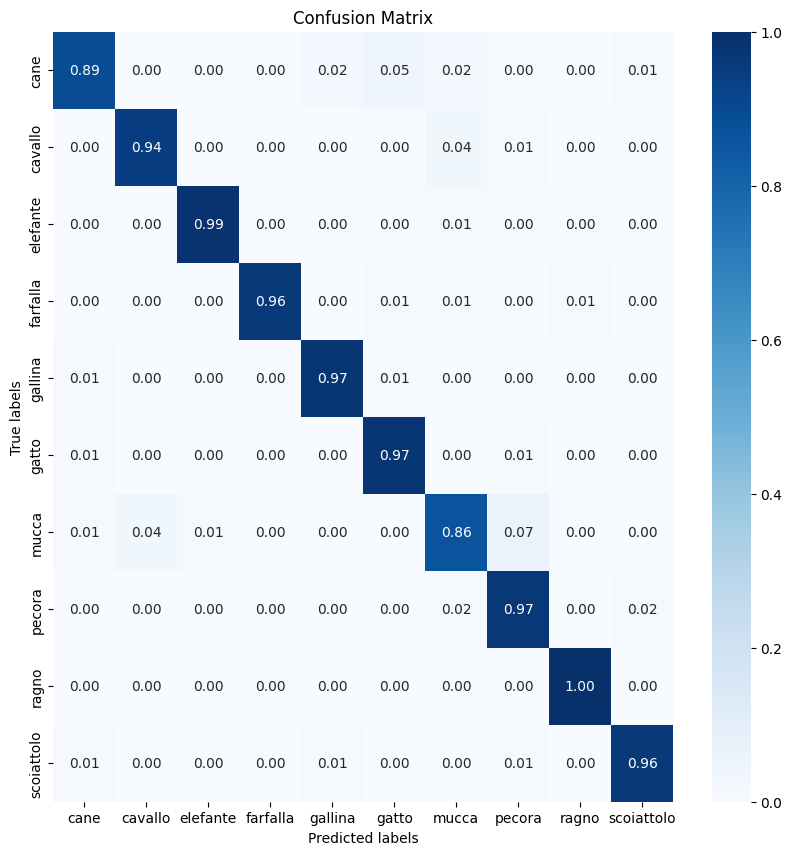

In [ ]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results

# Test the base MobileNetV2 model
accuracy_best, y_true_best, y_pred_best = test_model(test_set, mobilenet_v2, device)

print("Best MobileNetV2 Model:")
print(classification_report(y_true_best, y_pred_best, target_names=dataset.classes))

plot_confusion_matrix(y_true_best, y_pred_best, dataset.classes)


In [38]:
## Compare the best fine-tuned MobileNet model performance with the best CNN model implemented from scratch
## Compare the best fine-tuned MobileNet model performance with the best ResNet18 model implemented from scratch

### 2.10 Kaggle Test Result (5 points)
* Put your Kaggle test result for your MobileNet pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

# Transfer Learning vs. Training from Scratch

## Transfer Learning

**Advantages**:
- **Saves time**: Pre-trained models have already learned useful features.
- **Works with small datasets**: Great when you don’t have a lot of data.
- **Better generalization**: Models are good at adapting to various tasks.

**Disadvantages**:
- **Can overfit**: Might not perform well if your data is very different.
- **Limited flexibility**: May not be fully tailored to your task.

## Training from Scratch

**Advantages**:
- **Customizable**: Full control over the model design.
- **Tailored to your data**: Learns from your specific dataset.

**Disadvantages**:
- **Time-consuming**: Takes longer to train.
- **Needs a lot of data**: Small datasets lead to overfitting.
- **Resource-intensive**: Requires more computational power.

---

# Comparing the Models

| **Model**          | **Accuracy** | **Precision** | **Recall** | **F1-Score** |
|--------------------|--------------|---------------|------------|--------------|
| **CNN from Scratch**| 46.13%       | 0.46          | 0.46       | 0.46         |
| **ResNet18**        | 94.00%       | 0.95          | 0.94       | 0.94         |
| **MobileNet**       | 95.00%       | 0.95          | 0.94       | 0.95         |

---

# Practical Considerations

- **Use Transfer Learning**:
  - If you have a small dataset.
  - When you need faster results or have limited resources.
  - If your task is similar to the data the model was trained on.

- **Train from Scratch**:
  - If you have a large, specific dataset.
  - When you need full control over the model design.

- **Choosing a Model**:
  - **ResNet18**: High accuracy, good for fine-tuning.
  - **MobileNet**: Efficient, good for mobile or resource-limited devices.
  - **CNN from Scratch**: Custom, but requires a lot of data and time.


